In [ ]:
import pandas as pd
import numpy as np
import duckdb

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model
from keras import regularizers
from keras import Sequential

from sklearn.preprocessing import Normalizer, MinMaxScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('../assets/archive.csv', on_bad_lines='skip', sep=";")
train.rename(columns={0: 'id_transaction',
                        1: 'date',
                        2: 'card',
                        3: 'client',
                        4: 'date_of_birth',
                        5: 'passport',
                        6: 'passport_valid_to',
                        7: 'phone',
                        8: 'operation_type',
                        9: 'amount',
                        10: 'operation_result',
                        11: 'terminal_type',
                        12: 'city',
                        13: 'address',
                        }, inplace=True)

In [ ]:
test = pd.read_csv('../assets/archive_2.csv', on_bad_lines='skip', sep=";")
test.rename(columns={0: 'id_transaction',
                        1: 'date',
                        2: 'card',
                        3: 'client',
                        4: 'date_of_birth',
                        5: 'passport',
                        6: 'passport_valid_to',
                        7: 'phone',
                        8: 'operation_type',
                        9: 'amount',
                        10: 'operation_result',
                        11: 'terminal_type',
                        12: 'city',
                        13: 'address',
                        }, inplace=True)

In [ ]:
def check_passport_validity(con):
    con.sql("""
    UPDATE temp SET passport_validity_fraud =
    CASE
        WHEN TRY_CAST(passport_valid_to AS TIMESTAMP) IS NOT NULL
        AND TRY_CAST(date AS TIMESTAMP) > TRY_CAST(passport_valid_to AS TIMESTAMP)
        THEN TRUE
        ELSE FALSE
    END
    """)


def check_time_diff_fraud(con, time=10):
    con.sql(f"""
    UPDATE temp SET time_diff_fraud =
    CASE
        WHEN time_diff <= {time} THEN TRUE
        ELSE FALSE
    END
    """)


def check_time_address_diff(con, time=600):
    con.sql(f"""
    CREATE TEMP TABLE fraud_addresses AS
    SELECT DISTINCT client, address
    FROM temp
    WHERE changed_address AND time_diff < {time}
    """)

    con.sql("""
    UPDATE temp
    SET address_diff_fraud = TRUE
    WHERE temp.client IN (SELECT client FROM fraud_addresses)
    AND temp.address IN (SELECT address FROM fraud_addresses)
    """)


def check_time_city_diff(con, time=86400):
    con.sql(f"""
    CREATE TEMP TABLE fraud_citys AS
    SELECT DISTINCT client, city
    FROM temp
    WHERE changed_city = TRUE AND time_diff < {time}
    """)

    con.sql("""
    UPDATE temp
    SET city_diff_fraud = TRUE
    WHERE temp.client IN (SELECT client FROM fraud_citys)
    AND temp.city IN (SELECT city FROM fraud_citys)
    """)


def check_data_discrepancy_fraud(con):
    con.sql("""
    CREATE TEMP TABLE temp_counts AS
    SELECT client,
           COUNT(DISTINCT card) AS distinct_cards,
           COUNT(DISTINCT card || phone) AS distinct_combinations
    FROM temp
    GROUP BY client
    """)

    con.sql("""
    UPDATE temp
    SET data_discrepancy_fraud =
    (SELECT CASE
            WHEN temp_counts.distinct_cards < temp_counts.distinct_combinations THEN TRUE
            ELSE FALSE
            END
     FROM temp_counts
     WHERE temp.client = temp_counts.client)
    """)


def detect_hampel_outliers(con, window_size=18, n_sigmas=1.5):
    con.execute("SELECT amount FROM temp;")
    con.sql(f"""
    CREATE TEMP TABLE sorted_temp AS
    SELECT *,
           MEDIAN(amount) OVER (PARTITION BY client ORDER BY date ROWS BETWEEN {window_size} PRECEDING AND {window_size} FOLLOWING) AS rolling_median,
           AVG(amount) OVER (PARTITION BY client ORDER BY date ROWS BETWEEN {window_size} PRECEDING AND {window_size} FOLLOWING) AS rolling_avg,
           STDDEV_SAMP(amount) OVER (PARTITION BY client ORDER BY date ROWS BETWEEN {window_size} PRECEDING AND {window_size} FOLLOWING) AS rolling_stddev
    FROM temp
    """)

    con.sql(f"""
    UPDATE temp
    SET amount_outlier_fraud =
    CASE
        WHEN ABS(temp.amount - sorted_temp.rolling_avg) > {n_sigmas} * sorted_temp.rolling_stddev THEN TRUE
        ELSE FALSE
    END
    FROM sorted_temp
    WHERE temp.client = sorted_temp.client AND temp.date = sorted_temp.date
    """)


In [ ]:
def pipeline_for_feed(df, duckdb_con):
    duckdb_con.register("temp_df", df)

    duckdb_con.sql("""CREATE TEMP TABLE result AS SELECT *, EXTRACT(EPOCH FROM (TRY_CAST(date AS TIMESTAMP) - LAG(TRY_CAST(date AS TIMESTAMP))
        OVER (PARTITION BY client ORDER BY date))) AS time_diff FROM temp_df;""")
    duckdb_con.sql("ALTER TABLE result ADD COLUMN fraud_status BOOLEAN DEFAULT false")

    duckdb_con.sql("""
    CREATE TEMP TABLE temp AS
    SELECT *,
        EXTRACT(EPOCH FROM (TRY_CAST(date AS TIMESTAMP) - LAG(TRY_CAST(date AS TIMESTAMP))
        OVER (PARTITION BY client ORDER BY date))) AS time_diff,
        CASE WHEN address != LAG(address) OVER (PARTITION BY client ORDER BY date) THEN true ELSE false END AS changed_address,
        CASE WHEN city != LAG(city) OVER (PARTITION BY client ORDER BY date) THEN true ELSE false END AS changed_city,
    FROM temp_df
    """)

    duckdb_con.sql("ALTER TABLE temp ADD COLUMN passport_validity_fraud BOOLEAN DEFAULT false")
    duckdb_con.sql("ALTER TABLE temp ADD COLUMN time_diff_fraud BOOLEAN DEFAULT false")
    duckdb_con.sql("ALTER TABLE temp ADD COLUMN address_diff_fraud BOOLEAN DEFAULT false")
    duckdb_con.sql("ALTER TABLE temp ADD COLUMN city_diff_fraud BOOLEAN DEFAULT false")
    duckdb_con.sql("ALTER TABLE temp ADD COLUMN data_discrepancy_fraud BOOLEAN DEFAULT false")
    duckdb_con.sql("ALTER TABLE temp ADD COLUMN amount_outlier_fraud BOOLEAN DEFAULT false")

    check_passport_validity(duckdb_con)
    check_time_diff_fraud(duckdb_con)
    check_time_address_diff(duckdb_con)
    check_time_city_diff(duckdb_con)
    check_data_discrepancy_fraud(duckdb_con)
    detect_hampel_outliers(duckdb_con)

    duckdb_con.sql(f"""
    CREATE TEMP TABLE fraud_transactions AS
    SELECT DISTINCT id_transaction
    FROM temp
    WHERE passport_validity_fraud OR time_diff_fraud OR address_diff_fraud OR city_diff_fraud OR data_discrepancy_fraud OR amount_outlier_fraud
    """)

    duckdb_con.sql("""
    UPDATE result
    SET fraud_status = TRUE
    WHERE id_transaction IN (SELECT id_transaction FROM fraud_transactions)
    """)


    result_df = duckdb_con.sql("SELECT client, operation_type, terminal_type, amount, fraud_status FROM result ORDER BY date;").df()

    duckdb_con.close()

    return result_df


In [ ]:
con = duckdb.connect(":memory:")
train_df = pipeline_for_feed(train, con)

In [ ]:
train_df.head()

,client,operation_type,terminal_type,amount,fraud_status
0,3-95409,Оплата,POS,229532.3,False
1,8-17320,Пополнение,ATM,100.0,False
2,8-73435,Снятие,ATM,2800.0,False
3,5-20116,Пополнение,ATM,3900.0,False
4,3-26968,Пополнение,ATM,14800.0,False


In [8]:
con = duckdb.connect(":memory:")
test_df = pipeline_for_feed(test, con)

In [9]:
median_amounts = train_df.groupby('client')['amount'].transform(lambda x: x.mean())
train_df['amount'] = train_df['amount'] / median_amounts
train_df = train_df.drop(['client'], axis=1)

In [10]:
median_amounts = test_df.groupby('client')['amount'].transform(lambda x: x.mean())
test_df['amount'] = test_df['amount'] / median_amounts
test_df = test_df.drop(['client'], axis=1)

In [11]:
test_df.head()

,operation_type,terminal_type,amount,fraud_status
0,Пополнение,ATM,1.500000,False
1,Перевод,WEB,0.512989,False
2,Оплата,WEB,1.066815,False
3,Снятие,ATM,1.047619,False
4,Пополнение,ATM,1.272727,False


In [12]:
operation_mapping = {'Оплата': 1, 'Перевод': 2, 'Пополнение': 3, 'Снятие': 4}
terimnal_mapping = {'ATM': 1, 'POS': 2, 'WEB': 3}

train_df['operation_type'] = train_df['operation_type'].map(operation_mapping)
train_df['terminal_type'] = train_df['terminal_type'].map(terimnal_mapping)

test_df['operation_type'] = test_df['operation_type'].map(operation_mapping)
test_df['terminal_type'] = test_df['terminal_type'].map(terimnal_mapping)

In [13]:
train_df.columns

Index(['operation_type', 'terminal_type', 'amount', 'fraud_status'], dtype='object')

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102412 entries, 0 to 102411
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   operation_type  102412 non-null  int64  
 1   terminal_type   102412 non-null  int64  
 2   amount          102412 non-null  float64
 3   fraud_status    102412 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 2.4 MB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18374 entries, 0 to 18373
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   operation_type  18374 non-null  int64  
 1   terminal_type   18374 non-null  int64  
 2   amount          18374 non-null  float64
 3   fraud_status    18374 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 448.7 KB


In [16]:
train_df.head()

,operation_type,terminal_type,amount,fraud_status
0,1,2,1.000000,False
1,3,1,0.285714,False
2,4,1,1.000000,False
3,3,1,1.114286,False
4,3,1,1.193548,False


In [17]:
res_df = pd.concat([train_df, test_df])

In [18]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120786 entries, 0 to 18373
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   operation_type  120786 non-null  int64  
 1   terminal_type   120786 non-null  int64  
 2   amount          120786 non-null  float64
 3   fraud_status    120786 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 3.8 MB


In [77]:
fraud = train_df[train_df.fraud_status == 1]
clean = train_df[train_df.fraud_status == 0]

In [20]:
len(fraud)

3878

In [21]:
len(clean) / len(fraud)

25.408457968024756

In [22]:
RATIO_TO_FRAUD = 15
RANDOM_SEED = 42

In [23]:
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=42
)

In [24]:
len(clean_undersampled)

58170

In [25]:
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('fraud_status', axis=1).columns)

In [26]:
features, labels = visualisation_initial.drop('fraud_status', axis=1).values, \
                   visualisation_initial.fraud_status.values

In [27]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 98,534 to 58,170.
This represents a ratio of 15:1 to fraud.


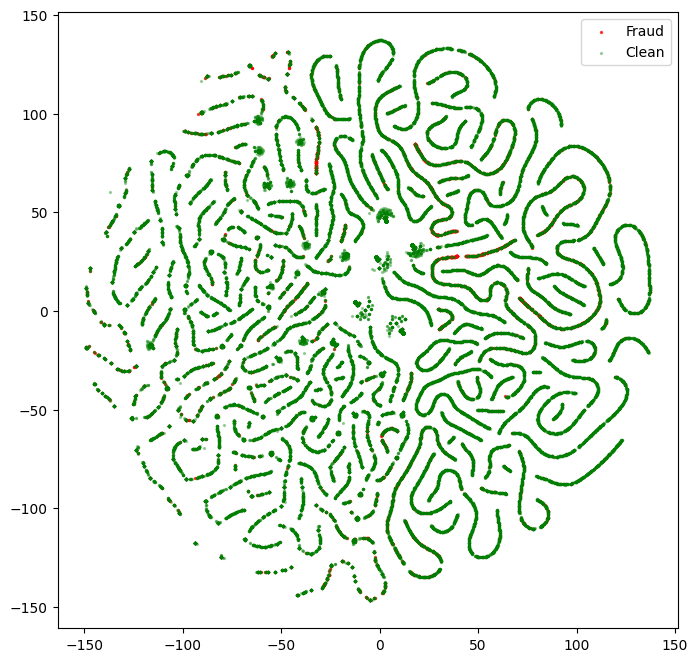

In [28]:
def tsne_scatter(features, labels, dimensions=2):
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

    fig, ax = plt.subplots(figsize=(8, 8))

    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    plt.legend(loc='best')
    plt.show;


tsne_scatter(features, labels, dimensions=2)

In [29]:
clean.head()

,operation_type,terminal_type,amount,fraud_status
0,1,2,1.000000,False
1,3,1,0.285714,False
2,4,1,1.000000,False
3,3,1,1.114286,False
4,3,1,1.193548,False


In [78]:
clean = clean.sample(frac=1).reset_index(drop=True)

In [79]:
X_train = clean.drop('fraud_status', axis=1)

In [80]:
X_test = pd.concat([test_df, fraud], ignore_index=True)

In [81]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22252 entries, 0 to 22251
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   operation_type  22252 non-null  int64  
 1   terminal_type   22252 non-null  int64  
 2   amount          22252 non-null  float64
 3   fraud_status    22252 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 543.4 KB


In [82]:
len(X_test[X_test.fraud_status == 1])

4473

In [83]:
X_train, X_validate = train_test_split(X_train,
                                       test_size=0.2,
                                       random_state=RANDOM_SEED)

In [84]:
X_test, y_test = X_test.drop('fraud_status', axis=1), X_test.fraud_status.values

In [85]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    test  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (78827, 3)
    validate (rows, cols) = (19707, 3)
    test  (rows, cols) = (22252, 3)


In [86]:
pipeline = Pipeline([
                     ('scaler', MinMaxScaler())])

In [87]:
mn = np.min(X_train, axis=0)
mx = np.max(X_train, axis=0)

In [88]:
mn

operation_type    1.000000
terminal_type     1.000000
amount            0.000389
dtype: float64

In [89]:
mx

operation_type    4.000000
terminal_type     3.000000
amount            3.973381
dtype: float64

In [90]:
pipeline.fit(X_train);

In [91]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

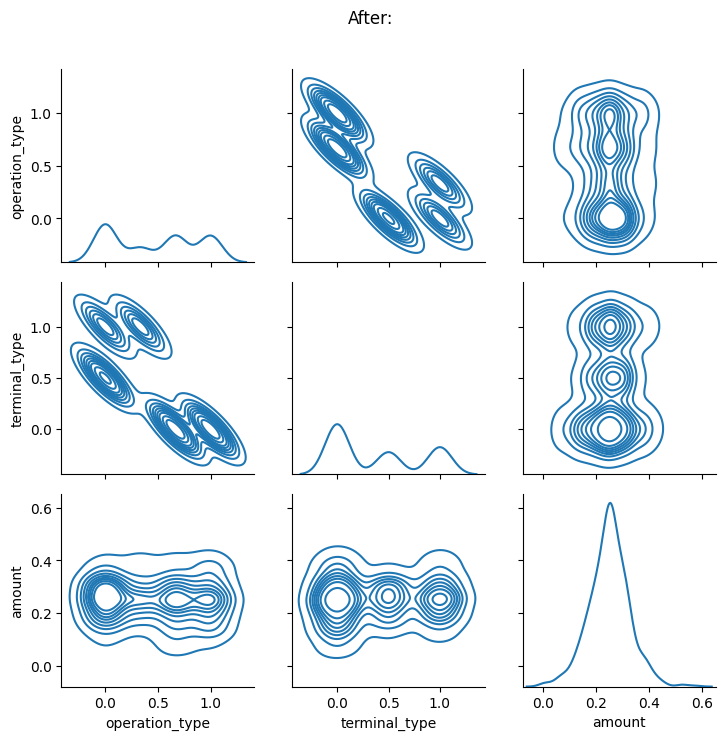

In [92]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.figure.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

In [112]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 512
EPOCHS = 100

autoencoder = tf.keras.models.Sequential([
    Dense(input_dim, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(128, activation='elu'),
    Dropout(0.5),
    Dense(64, activation='elu'),
    Dropout(0.5),
    Dense(32, activation='elu'),
    Dropout(0.5),
    Dense(16, activation='elu'),
    Dense(32, activation='elu'),
    Dense(64, activation='elu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 3)                 12        
                                                                 
 batch_normalization_11 (Ba  (None, 3)                 12        
 tchNormalization)                                               
                                                                 
 dense_41 (Dense)            (None, 128)               512       
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [113]:
history = autoencoder.fit(
    tf.convert_to_tensor(X_train_transformed), tf.convert_to_tensor(X_train_transformed),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(tf.convert_to_tensor(X_validate_transformed), tf.convert_to_tensor(X_validate_transformed))
)

Epoch 1/100
154/154 [==============================] - 5s 19ms/step - loss: 0.0380 - val_loss: 0.0237
Epoch 2/100
154/154 [==============================] - 2s 11ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 3/100
154/154 [==============================] - 1s 9ms/step - loss: 0.0115 - val_loss: 0.0089
Epoch 4/100
154/154 [==============================] - 1s 9ms/step - loss: 0.0105 - val_loss: 0.0088
Epoch 5/100
154/154 [==============================] - 1s 9ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 6/100
154/154 [==============================] - 2s 10ms/step - loss: 0.0100 - val_loss: 0.0082
Epoch 7/100
154/154 [==============================] - 3s 19ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 8/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0095 - val_loss: 0.0080
Epoch 9/100
154/154 [==============================] - 2s 14ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 10/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0094 -

In [114]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

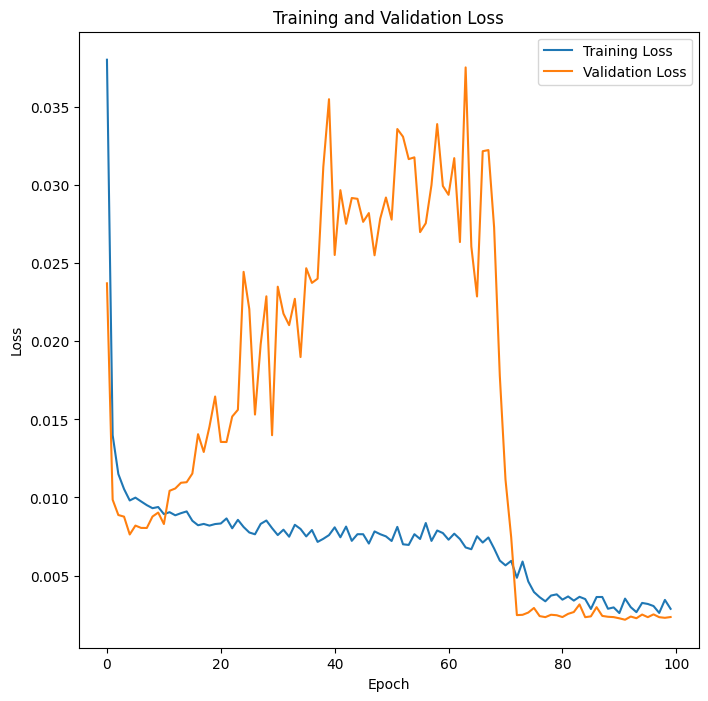

In [115]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

In [124]:
autoencoder.save('gitkeep1.h5')

In [116]:
X_test_transformed = pipeline.transform(X_test)

reconstructions = autoencoder.predict(X_test_transformed)

696/696 [==============================] - 1s 2ms/step


In [117]:
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

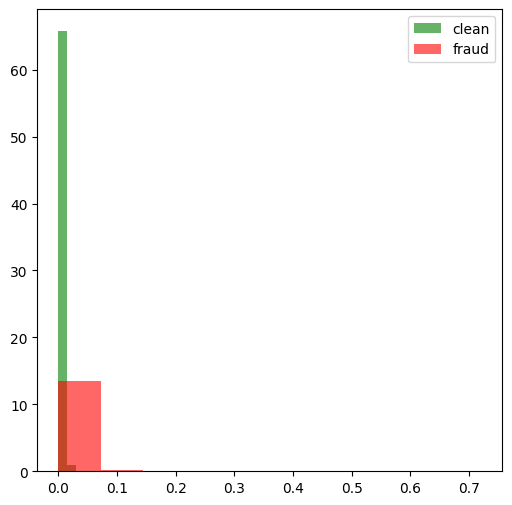

In [125]:
clean_mse = mse[y_test==0]
fraud_mse = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6, 6))

ax.hist(clean_mse, bins=10, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud_mse, bins=10, density=True, label="fraud", alpha=.6, color="red")

plt.legend()
plt.show()

In [119]:
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

z_scores = mad_score(mse)

outliers = z_scores > np.quantile(z_scores, 0.90)

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers) / np.size(z_scores):.2%}].")

Detected 2,225 outliers in a total of 22,252 transactions [10.00%].


In [120]:
from sklearn.metrics import (confusion_matrix,
                             precision_recall_curve)

cm = confusion_matrix(y_test, outliers)

(tn, fp,
 fn, tp) = cm.flatten()

In [121]:
print(f"""The classifications using the MAD method with threshold= are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold= are as follows:
[[16908   871]
 [ 3119  1354]]

% of transactions labeled as fraud that were correct (precision): 1354/(871+1354) = 60.85%
% of fraudulent transactions were caught succesfully (recall):    1354/(3119+1354) = 30.27%


In [122]:
print(classification_report(y_test, outliers))

              precision    recall  f1-score   support

       False       0.84      0.95      0.89     17779
        True       0.61      0.30      0.40      4473

    accuracy                           0.82     22252
   macro avg       0.73      0.63      0.65     22252
weighted avg       0.80      0.82      0.80     22252

